In [1]:
import numpy as np
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import random
import tensorflow as tf

2024-02-15 16:17:16.935359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 16:17:16.935517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 16:17:17.127435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Introduction
This notebook demonstrates model inference using my pretrained models. The purpose of this notebook is to provide visualizations of the results.

In [2]:
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

# Define a function to combine EncodedPixels
def combine_encoded_pixels(s):
    s = s.dropna()
    if s.empty:
        return np.nan
    else:
        return ' '.join(s)
df = df[-200:]
# Combine EncodedPixels values for each unique ImageId
df = df.groupby('ImageId')['EncodedPixels'].apply(combine_encoded_pixels).reset_index()

# Required functions

In [3]:
def preprocess_image(image_name, base_path, target_size=(224, 224)):
    # Construct full image path
    image_path = f"{base_path}/{image_name}"  # Update the path as needed
    
    # Load image
    image = cv2.imread(image_path)
    
    # Check if image was loaded successfully
    if image is None:
        print(f"Failed to load image at {image_path}")
        return None
    
    # Convert color space from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize to target size
    image = cv2.resize(image, target_size)
    
    # Normalize pixel values
    image = image / 255.0
    
    return image


def rle_decode(mask_rle, shape=(768, 768), new_shape=(224, 224)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    new_shape: (height,width) of the resized array
    Returns numpy array, 1 - mask, 0 - background

    '''
    if pd.isna(mask_rle):
        # No object, create a zero-filled mask
        return np.zeros(new_shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape).T
    img = cv2.resize(img, new_shape)
    return img.astype(np.uint8)

def rle_encode(img, shape=(768, 768), new_shape=(224, 224), threshold=0.4):
    '''
    img: 2D numpy array of shape (height, width)
    shape: (height,width) of the original array 
    new_shape: (height,width) of the resized array
    threshold: a value to binarize the input array
    Returns run-length as string formated (start length)
    '''
    # Binarize the input array based on the given threshold
    img = np.where(img > threshold, 1, 0)
    if np.sum(img) == 0:
        return np.nan
    img = cv2.resize(img, shape, interpolation=cv2.INTER_NEAREST)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Loading models

In [4]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)

    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
custom_objects = {'dice_coef': dice_coef}
segmentation_model = tf.keras.models.load_model('/kaggle/input/segmenation-model-for-airbus-ship-detection/segmentation_model (1).h5', custom_objects=custom_objects)

In [6]:
classification_model = tf.keras.models.load_model('/kaggle/input/classification-model-for-airbus-ship-detection/classification_model.h5')

# Function to display the model on training images to display the result (the models was not trained on these images)

1/1 [==============================] - 1s 1s/step
Mask was predicted.


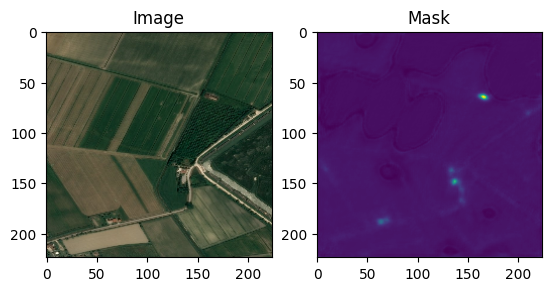

1/1 [==============================] - 0s 176ms/step
No ships were found.


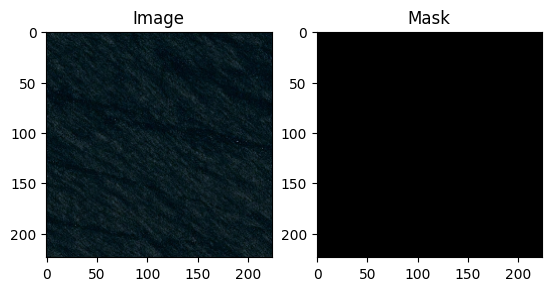

1/1 [==============================] - 0s 158ms/step
No ships were found.


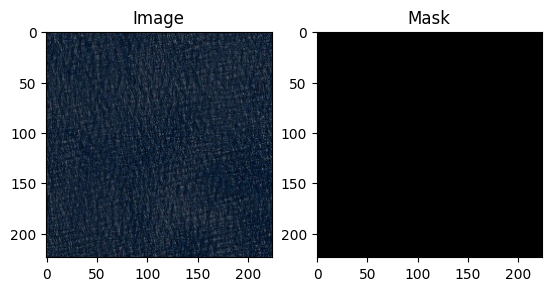

1/1 [==============================] - 0s 156ms/step
No ships were found.


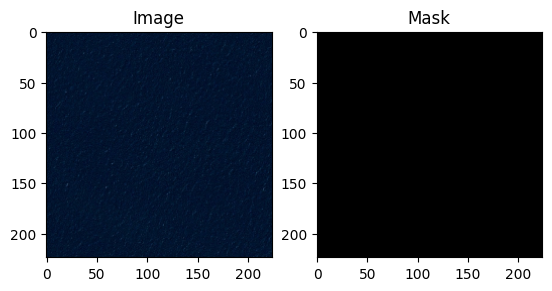

1/1 [==============================] - 0s 168ms/step
No ships were found.


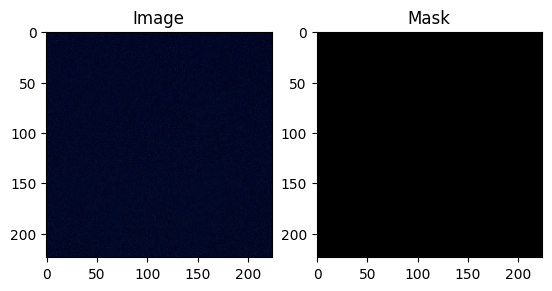

1/1 [==============================] - 0s 166ms/step
No ships were found.


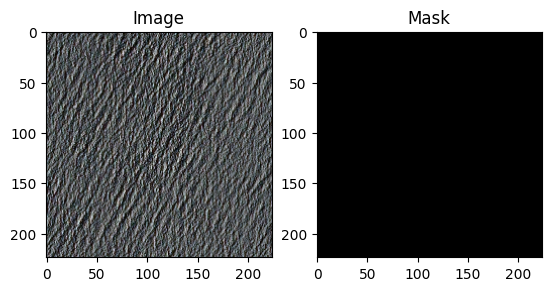

1/1 [==============================] - 0s 76ms/step
Mask was predicted.


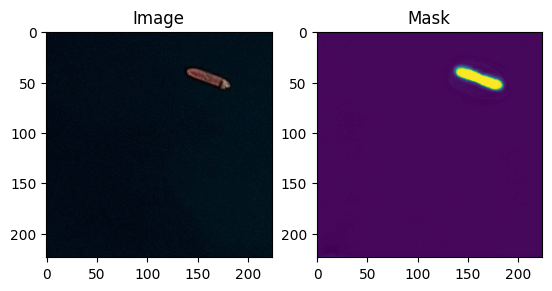

1/1 [==============================] - 0s 160ms/step
No ships were found.


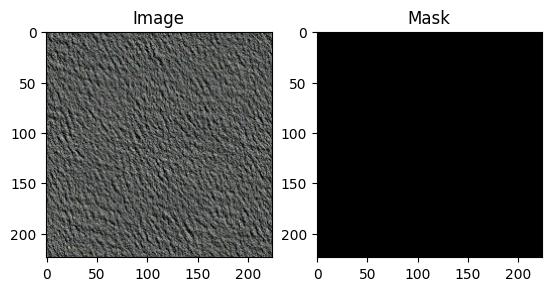

1/1 [==============================] - 0s 161ms/step
No ships were found.


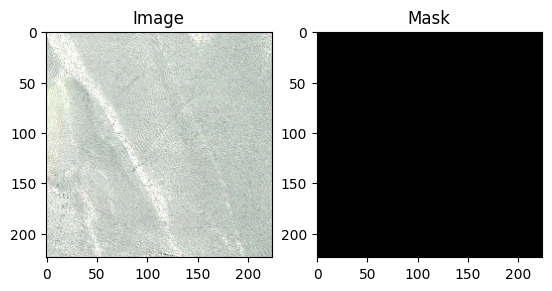

1/1 [==============================] - 0s 91ms/step
Mask was predicted.


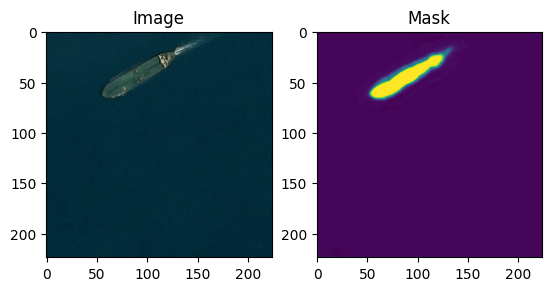

In [7]:
def process_images(df, base_path, show_results=False):
    # Initialize an empty list to store the encoded pixels
    encoded_pixels = []

    # Iterate over each image
    for image_name in df['ImageId']:
        # Preprocess image
        image = preprocess_image(image_name, base_path)
        image = np.expand_dims(image, axis=0)

        # Predict with classification model
        pred = classification_model.predict(image)

        if pred < 0.5:
            if show_results:
                print('No ships were found.')
            # Create an empty mask
            mask = np.zeros_like(image)
        else:
            # Predict with segmentation model
            mask = segmentation_model.predict(image)
            if show_results:
                print('Mask was predicted.')

        if show_results:
            # Show image and mask
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(np.squeeze(image, axis = 0))
            ax[0].set_title('Image')
            ax[1].imshow(np.squeeze(mask, axis=0))
            ax[1].set_title('Mask')
            plt.show()

        # Append the result of rle_encode function on prediction to the list
        encoded_pixels.append(rle_encode(np.squeeze(mask, axis = 0)))

    # Add the encoded pixels as a new column to the DataFrame
    df['EncodedPixels'] = encoded_pixels


# Read CSV file with image names
check_df = df.sample(n=10)

# Call the function
process_images(check_df, '/kaggle/input/airbus-ship-detection/train_v2', show_results=True)

In [8]:
check_df

,ImageId,EncodedPixels
30,ffcc5857f.jpg,429533 7 430301 7 431069 7 431837 7 432605 10 ...
65,ffd7a32e9.jpg,NaN
59,ffd532d43.jpg,NaN
128,fff0464c0.jpg,NaN
103,ffe744a4c.jpg,NaN
78,ffdd62e14.jpg,NaN
24,ffc848f0a.jpg,361092 13 361860 13 362628 13 363396 13 364157...
40,ffd0a9c5a.jpg,NaN
95,ffe49dbce.jpg,NaN
144,fff77c602.jpg,137679 14 138447 14 139215 14 139980 20 140748...


1/1 [==============================] - 0s 156ms/step
No ships were found.


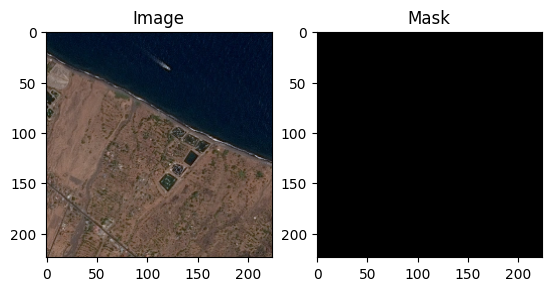

1/1 [==============================] - 0s 159ms/step
No ships were found.


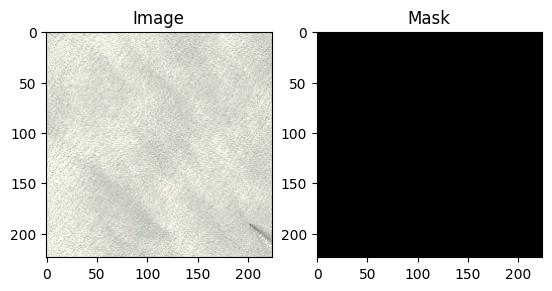

1/1 [==============================] - 0s 82ms/step
Mask was predicted.


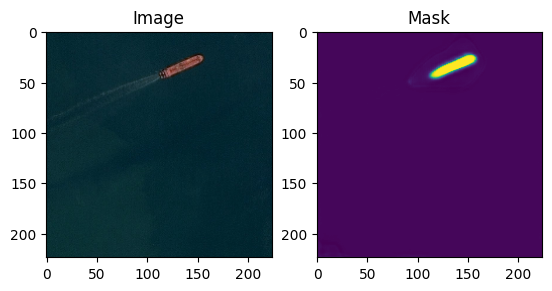

1/1 [==============================] - 0s 78ms/step
Mask was predicted.


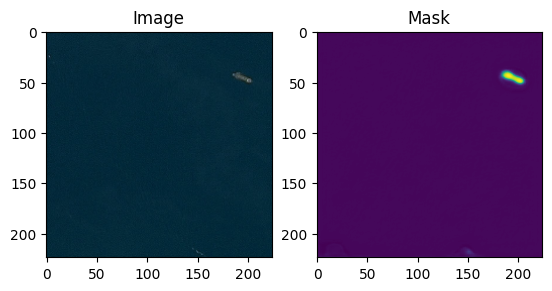

1/1 [==============================] - 0s 162ms/step
No ships were found.


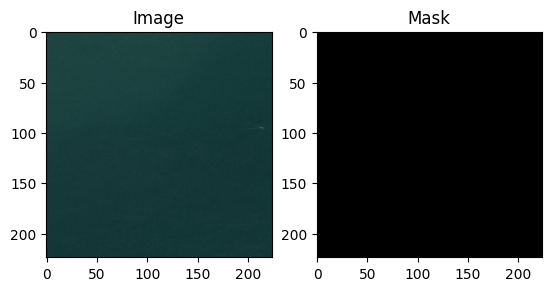

1/1 [==============================] - 0s 85ms/step
Mask was predicted.


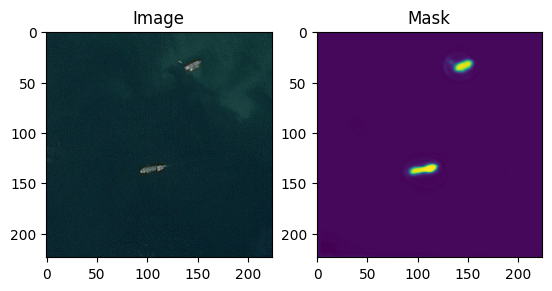

1/1 [==============================] - 0s 80ms/step
Mask was predicted.


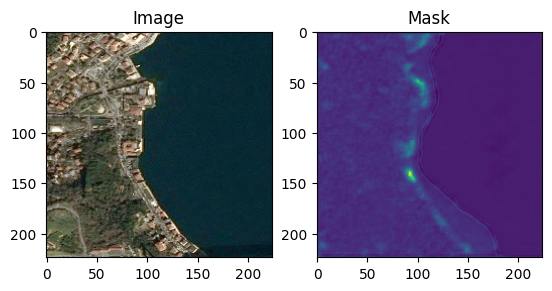

1/1 [==============================] - 0s 82ms/step
Mask was predicted.


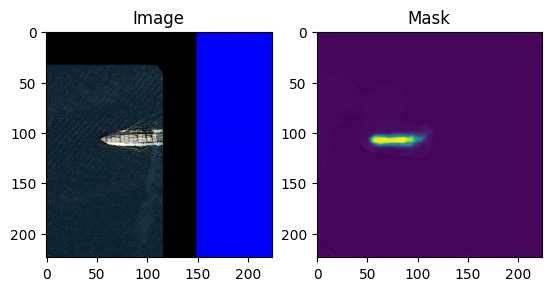

1/1 [==============================] - 0s 82ms/step
Mask was predicted.


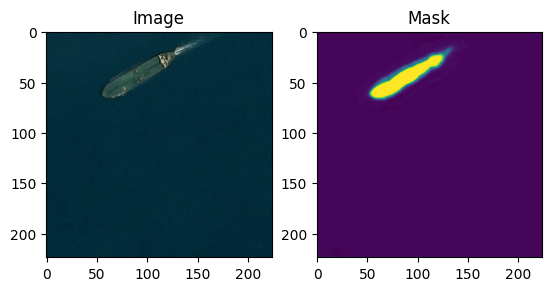

1/1 [==============================] - 0s 91ms/step
Mask was predicted.


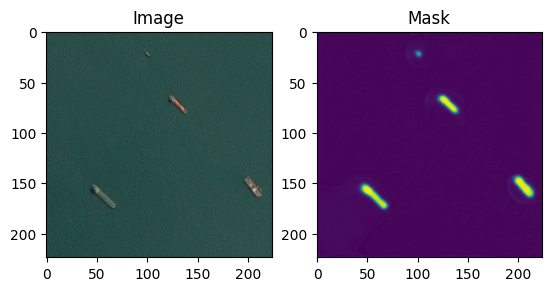

In [9]:
def process_images(df, base_path, show_results=False):
    # Initialize an empty list to store the encoded pixels
    encoded_pixels = []

    # Iterate over each image
    for image_name in df['ImageId']:
        # Preprocess image
        image = preprocess_image(image_name, base_path)
        image = np.expand_dims(image, axis=0)

        # Predict with classification model
        pred = classification_model.predict(image)

        if pred < 0.5:
            if show_results:
                print('No ships were found.')
            # Create an empty mask
            mask = np.zeros_like(image)
        else:
            # Predict with segmentation model
            mask = segmentation_model.predict(image)
            if show_results:
                print('Mask was predicted.')

        if show_results:
            # Show image and mask
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(np.squeeze(image, axis = 0))
            ax[0].set_title('Image')
            ax[1].imshow(np.squeeze(mask, axis=0))
            ax[1].set_title('Mask')
            plt.show()

        # Append the result of rle_encode function on prediction to the list
        encoded_pixels.append(rle_encode(np.squeeze(mask, axis = 0)))

    # Add the encoded pixels as a new column to the DataFrame
    df['EncodedPixels'] = encoded_pixels


# Read CSV file with image names
check_df = df.dropna()
check_df = check_df.sample(n=10)

# Call the function
process_images(check_df, '/kaggle/input/airbus-ship-detection/train_v2', show_results=True)

In [10]:
check_df

,ImageId,EncodedPixels
94,ffe3ee83a.jpg,NaN
140,fff529a0e.jpg,NaN
49,ffd20fd4f.jpg,295057 14 295825 14 296593 14 297361 14 298126...
70,ffd98caa2.jpg,482449 11 483217 11 483985 11 484747 20 485515...
86,ffe1d7e9a.jpg,NaN
83,ffdfe7893.jpg,243159 17 243927 17 244695 17 245460 20 246228...
117,ffec95ea3.jpg,NaN
4,ffc2a6de6.jpg,140141 14 140909 14 141677 14 142445 14 143209...
144,fff77c602.jpg,137679 14 138447 14 139215 14 139980 20 140748...
25,ffc90b7c8.jpg,116494 21 117262 21 118030 21 118798 21 119563...
